# Naïve Bayes algorithm for classification

This notebooks includes 4 different models

1. Gaussian Naive Bayes for Binary Classification (class2)
2. Gaussian Naive Bayes for Binary Classification (class2) with normalized features
3. Gaussian Naive Bayes for Multiclass Classification (class4)
4. Gaussian Naive Bayes for Multiclass Classification (class4) with normalized features

In [768]:
import pickle
import json
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing 
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler

#os.chdir('/Users/bwilliams/GoogleDrive/UniversityOfHelsinki/Fall2020/IML/TeamProject/TermProjectIML/bin')
os.chdir('C:/Users/saukk/Desktop/ML_Project/bin')
from SplitData import *

### Define help function

In [769]:
def print_nbr_classes(name, df):
    '''
    input:
        name: string used as print header
        df: dataframe which has column named class4 that includes categorical values nonevent, II, Ib, Ia
    output:
        Print that has count of every categorical value and how many percent that represents
    '''
    set_size=len(df)
    print(name, "set")
    print("nonevent:", len(df[df["class4"]=="nonevent"]), "pcs", round(len(df[df["class4"]=="nonevent"])/set_size, 3), "%")
    print("II:", len(df[df["class4"]=="II"]), "pcs", round(len(df[df["class4"]=="II"])/set_size, 3), "%")
    print("Ib:", len(df[df["class4"]=="Ib"]), "pcs", round(len(df[df["class4"]=="Ib"])/set_size, 3), "%")
    print("Ia:", len(df[df["class4"]=="Ia"]), "pcs", round(len(df[df["class4"]=="Ia"])/set_size, 3), "%")
    print("Total:", set_size, "pcs")
    print("")

def data_cleaner(df):
    '''
    input:
        df: dataframe
    output:
        df: dataframe
    '''
    data = df.copy()
    data.drop(["id","partlybad", "date"],1,inplace=True)
    data["class2"] = np.where(data["class4"] == "nonevent", "nonevent","event")
    cols = ['class2'] + [col for col in data if col != 'class2']
    return data[cols]

def normalize_0to1(df):
    '''
    input:
        df: dataframe
    output:
        df: dataframe
    '''
    scaler = MinMaxScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df_norm

def find_n_best_feature(X, y, n):
    '''
    input:
        X:
        y:
        n:
    output:
     cols:
    '''
    bestfeatures = SelectKBest(score_func=chi2, k=n)
    fit = bestfeatures.fit(X_train_norm, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_train_norm.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['col_name','Score']
    featureScores= featureScores.nlargest(n,'Score')
    cols = list(featureScores["col_name"])
    return cols

### Import data and print length and categorical distribution

In [770]:
X_train = X_train
X_train_norm = X_train_norm
y_train = y_train
y_train_bin = convert_binary(y_train)
print("Train set")
print("Len:",len(y_train))
print(y_train.value_counts(normalize=True),"\n")

X_test = X_test
X_test_norm = X_test_norm
y_test = y_test
y_test_bin = convert_binary(y_test)
print("Test set")
print("Len:",len(y_test))
print(y_test.value_counts(normalize=True),"\n")

X_val = X_val
X_val_norm = X_val_norm
y_val = y_val
y_val_bin = convert_binary(y_val)
print("Validation set")
print("Len:",len(y_val))
print(y_val.value_counts(normalize=True),"\n")

X_trainval = X_trainval
X_trainval_norm = X_trainval_norm
y_trainval = y_trainval
y_trainval_bin = convert_binary(y_trainval)
print("Trainvalidation set")
print("Len:",len(y_trainval))
print(y_trainval.value_counts(normalize=True),"\n")

os.chdir('C:/Users/saukk/Desktop/ML_Project')
npf_train = pd.read_csv("data/npf_train.csv")
npf_train = data_cleaner(npf_train)
print_nbr_classes("npf_train", npf_train)

Train set
Len: 154
nonevent    0.493506
II          0.220779
Ib          0.214286
Ia          0.071429
Name: class4, dtype: float64 

Test set
Len: 52
nonevent    0.500000
II          0.211538
Ib          0.211538
Ia          0.076923
Name: class4, dtype: float64 

Validation set
Len: 52
nonevent    0.500000
II          0.211538
Ib          0.211538
Ia          0.076923
Name: class4, dtype: float64 

Trainvalidation set
Len: 206
nonevent    0.495146
II          0.218447
Ib          0.213592
Ia          0.072816
Name: class4, dtype: float64 

npf_train set
nonevent: 215 pcs 0.5 %
II: 106 pcs 0.247 %
Ib: 83 pcs 0.193 %
Ia: 26 pcs 0.06 %
Total: 430 pcs



### Make correlation matrix

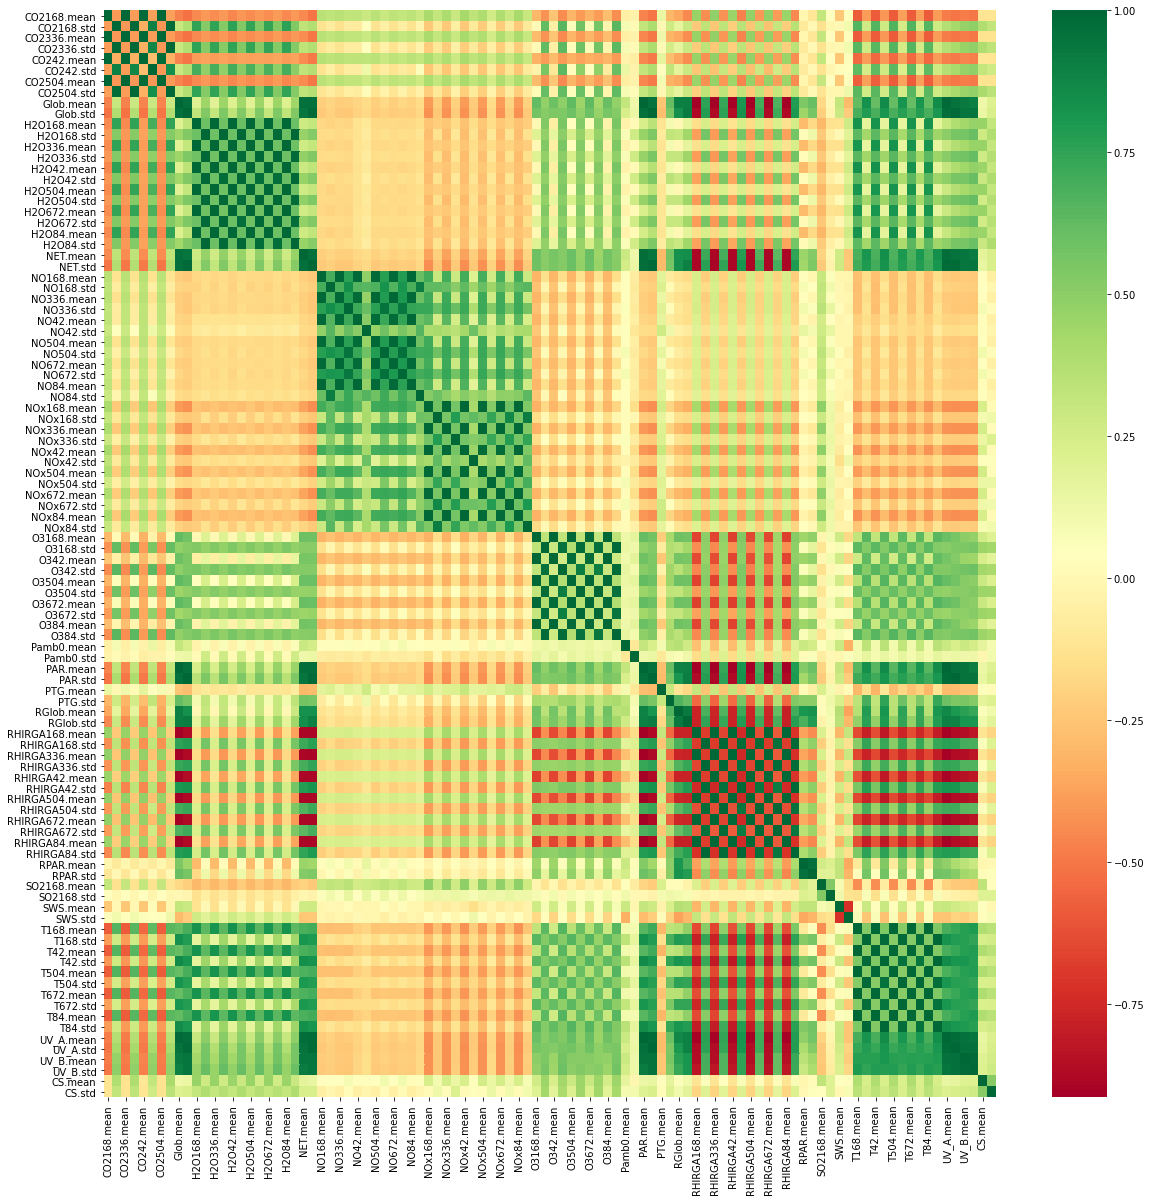

In [771]:
corrmat = npf_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(npf_train[top_corr_features].corr(),annot=False,cmap="RdYlGn")
plt.savefig('npf_train_correlationmatrix.pdf')  

## Find best features and print accuracy graph

SelectKBest method find correlation between every class and feature. Then it gives these feature correlation scores and sorts result by score. Then we search the number of best features, that gives best training accuracy.

In [772]:
def bestK_and_graph(X_train, y_train, X_val, y_val, X_test, y_test, title):
    
    len_cols = len(X_train.columns)+1
    acc_train = []
    acc_test = []
    acc_val = []

    for i in range(1, len_cols):
    
        # Train filter with full dataset. Find i number of best col names.
        bestFeatureCols = find_n_best_feature(X_train, y_train, i)
    
        # Filter train, val and test set with bestFeaturesFilter
        X_train_i = X_train[bestFeatureCols]
        X_val_i = X_val[bestFeatureCols]
        X_test_i = X_test[bestFeatureCols]
        
        # Train Gaussian Naive Bayes model
        model = GaussianNB()
        model.fit(X_train_i, y_train)
    
        # Save accurancy to list
        acc_train.append(accuracy_score(y_train, model.predict(X_train_i)))
        acc_test.append(accuracy_score(y_test, model.predict(X_test_i)))
        acc_val.append(accuracy_score(y_val, model.predict(X_val_i)))

    acc_train_max = acc_train.index(max(acc_train))+1    
    
    # Plot the results
    figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    x = range(1, len_cols)
    plt.plot(x, acc_train, color="black")
    plt.plot(x, acc_test, color="blue")
    plt.plot(x, acc_val, color="green")
    # Vertical line to points with max values
    plt.axvline(acc_train_max, color='pink', linestyle='-')
    plt.title(title)
    plt.xlabel('Number of features')
    plt.ylabel('Accurancy')
    plt.legend(["train", "test", "val"], loc ="lower right") 
    plt.show()
    
    return acc_train_max

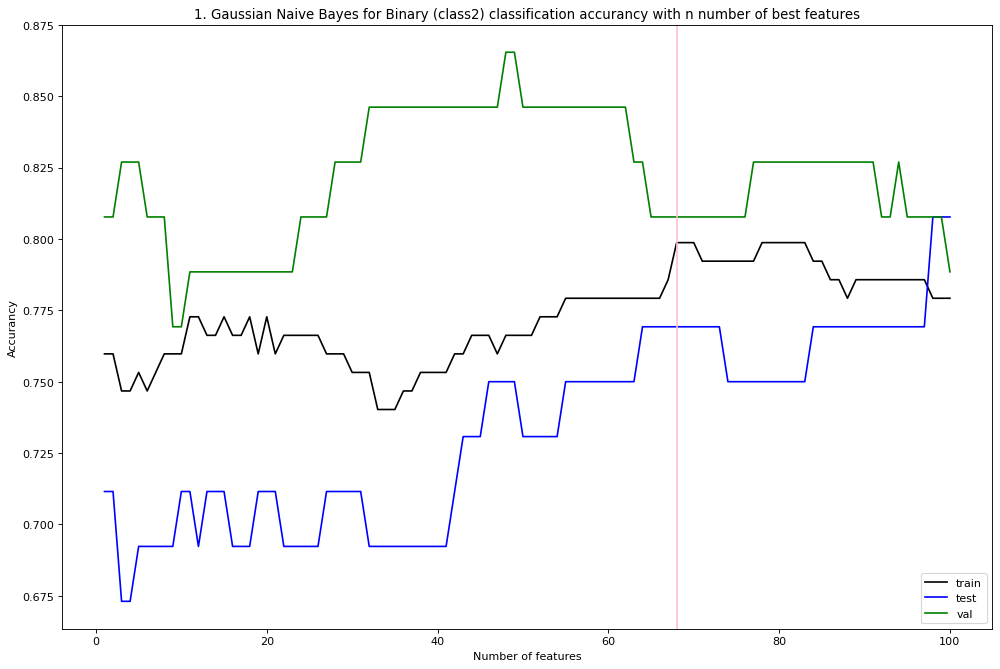

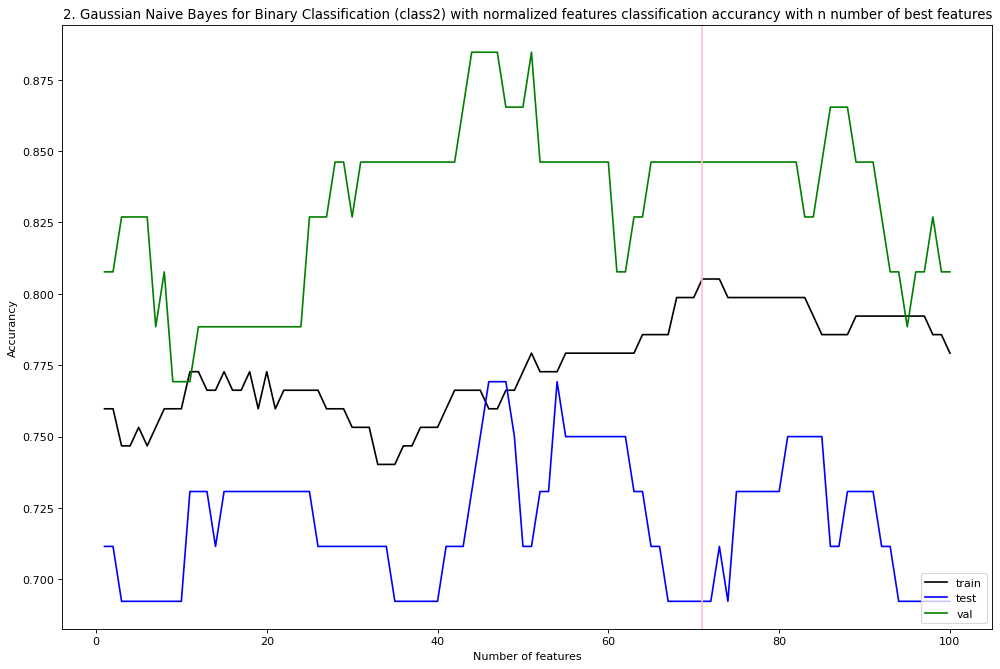

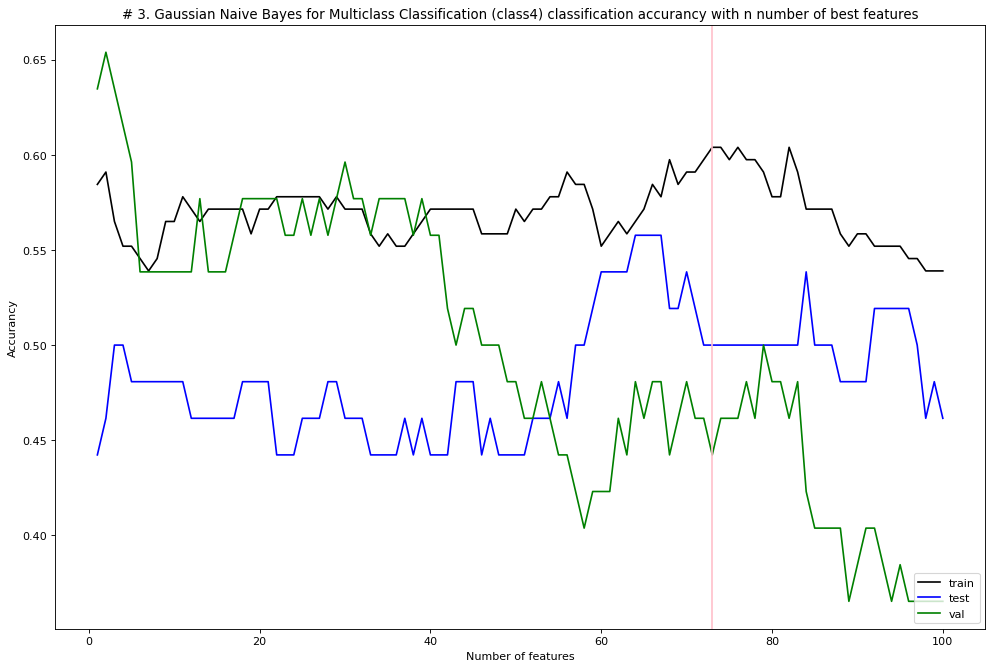

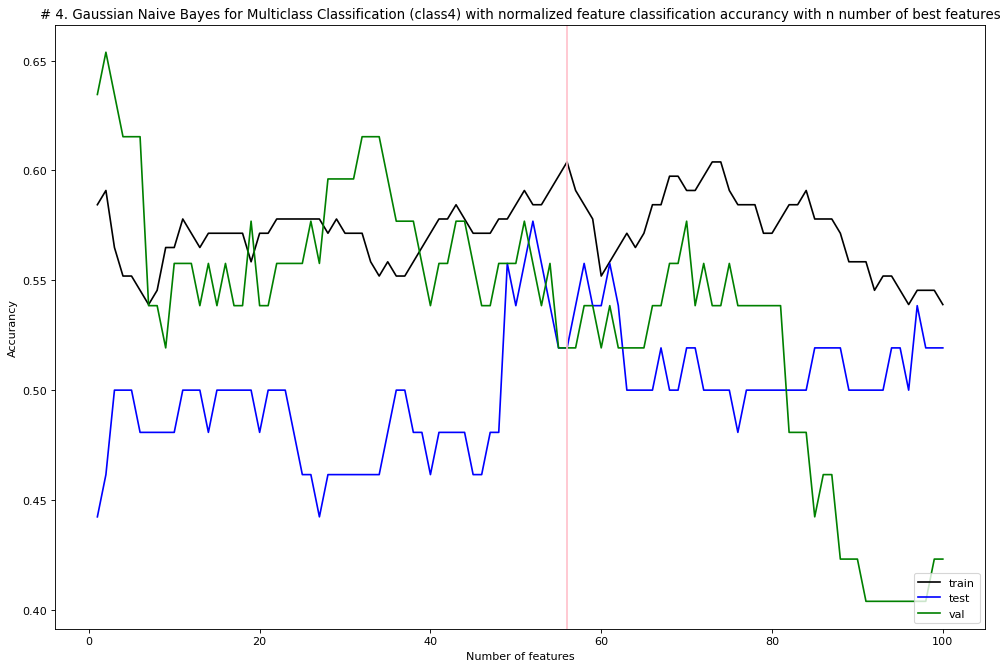

In [773]:
# 1. Gaussian Naive Bayes for Binary Classification (class2)
bestK1 = bestK_and_graph(X_train, y_train_bin, X_val, y_val_bin, X_test, y_test_bin, "1. Gaussian Naive Bayes for Binary (class2) classification accurancy with n number of best features")

# 2. Gaussian Naive Bayes for Binary Classification (class2) with normalized features
bestK2 = bestK_and_graph(X_train_norm, y_train_bin, X_val_norm, y_val_bin, X_test_norm, y_test_bin, "2. Gaussian Naive Bayes for Binary Classification (class2) with normalized features classification accurancy with n number of best features")

# 3. Gaussian Naive Bayes for Multiclass Classification (class4)
bestK3 = bestK_and_graph(X_train, y_train, X_val, y_val, X_test, y_test, "# 3. Gaussian Naive Bayes for Multiclass Classification (class4) classification accurancy with n number of best features")

# 4. Gaussian Naive Bayes for Multiclass Classification (class4) with normalized feature
bestK4 = bestK_and_graph(X_train_norm, y_train, X_val_norm, y_val, X_test_norm, y_test, "# 4. Gaussian Naive Bayes for Multiclass Classification (class4) with normalized feature classification accurancy with n number of best features")

## 1. Gaussian Naive Bayes Binary classification (class2)

### Gaussian Naive Bayes Binary accuracy for n number of kBest features

In [774]:
model = GaussianNB()
model.fit(X_train, y_train_bin)

print("Gaussian Naive Bayes binary classification")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val)), 2))

Gaussian Naive Bayes binary classification
Train set accurancy: 0.78
Test set accurancy: 0.81
Validation set accurancy: 0.79


In [775]:
# Train filter with full dataset. Find i number of best col names.
bestFeatureCols = find_n_best_feature(X_train, y_train_bin, bestK1)
    
# Filter train, val and test set with bestFeaturesFilter
X_train_i = X_train[bestFeatureCols]
X_val_i = X_val[bestFeatureCols]
X_test_i = X_test[bestFeatureCols]

model = GaussianNB()
model.fit(X_train_i, y_train_bin)

print("Gaussian Naive Bayes binary classification with", bestK1, "best features")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train_i)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test_i)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val_i)), 2))

Gaussian Naive Bayes binary classification with 68 best features
Train set accurancy: 0.8
Test set accurancy: 0.77
Validation set accurancy: 0.81


## 2. Gaussian Naive Bayes Binary classification (class2) normalized features

In [776]:
model = GaussianNB()
model.fit(X_train_norm, y_train_bin)

print("Gaussian Naive Bayes binary classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val_norm)), 2))

Gaussian Naive Bayes binary classification normalized features
Train set accurancy: 0.78
Test set accurancy: 0.69
Validation set accurancy: 0.81


In [777]:
# Train filter with full dataset. Find i number of best col names.
bestFeatureCols = find_n_best_feature(X_train_norm, y_train_bin, bestK2)
    
# Filter train, val and test set with bestFeaturesFilter
X_train_i = X_train_norm[bestFeatureCols]
X_val_i = X_val_norm[bestFeatureCols]
X_test_i = X_test_norm[bestFeatureCols]

model = GaussianNB()
model.fit(X_train_i, y_train_bin)

print("Gaussian Naive Bayes binary classification with", bestK2, "best normalized features")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train_i)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test_i)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val_i)), 2))

Gaussian Naive Bayes binary classification with 71 best normalized features
Train set accurancy: 0.81
Test set accurancy: 0.69
Validation set accurancy: 0.85


## 3. Gaussian Naive Bayes Multiclass classification (class4)

In [778]:
model = GaussianNB()
model.fit(X_train, y_train)

print("Gaussian Naive Bayes Multiclass classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Gaussian Naive Bayes Multiclass classification
Train set accurancy: 0.54
Test set accurancy: 0.46
Validation set accurancy: 0.37


In [779]:
# Train filter with full dataset. Find i number of best col names.
bestFeatureCols = find_n_best_feature(X_train, y_train, bestK3)
    
# Filter train, val and test set with bestFeaturesFilter
X_train_i = X_train[bestFeatureCols]
X_val_i = X_val[bestFeatureCols]
X_test_i = X_test[bestFeatureCols]

model = GaussianNB()
model.fit(X_train_i, y_train)

print("Gaussian Naive Bayes Multiclass classification with", bestK3, "best features")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train_i)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test_i)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val_i)), 2))

Gaussian Naive Bayes Multiclass classification with 73 best features
Train set accurancy: 0.6
Test set accurancy: 0.5
Validation set accurancy: 0.44


## 4. Gaussian Naive Bayes Multiclass classification (class4) normalized features

In [780]:
model = GaussianNB()
model.fit(X_train_norm, y_train)

print("Gaussian Naive Bayes Multiclass classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val_norm)), 2))

Gaussian Naive Bayes Multiclass classification normalized features
Train set accurancy: 0.54
Test set accurancy: 0.52
Validation set accurancy: 0.42


In [781]:
# Train filter with full dataset. Find i number of best col names.
bestFeatureCols = find_n_best_feature(X_train_norm, y_train, bestK4)
    
# Filter train, val and test set with bestFeaturesFilter
X_train_i = X_train_norm[bestFeatureCols]
X_val_i = X_val_norm[bestFeatureCols]
X_test_i = X_test_norm[bestFeatureCols]

model = GaussianNB()
model.fit(X_train_i, y_train)

print("Gaussian Naive Bayes Multiclass classification with", bestK4, "best normalized features")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train_i)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test_i)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val_i)), 2))

Gaussian Naive Bayes Multiclass classification with 56 best normalized features
Train set accurancy: 0.6
Test set accurancy: 0.52
Validation set accurancy: 0.52
